# Main Plotting of liftetime exposure FREQUENCY for water scarcity 
For water scarcity
Main script for plotting, does analysis based on script

In [3]:
import os
import xarray as xr
import pickle as pk
import time
import matplotlib as mpl
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from settings import *
from load_manip import *
from exposure import * 
from utils import *
from main_function import *
from maskplotting import *
import warnings 
  
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 
  
# Script to plot countries
from plotting import *

# set own plotting parameters
set_plot_param()
map_proj = ccrs.Robinson(central_longitude=0, globe=None)

%matplotlib inline 

In [6]:
# extreme event
global flags

flags = {}
flags['extr'] = 'waterdeficitduration'   # 0: all
#flags['extr'] = 'waterdeficit'   # 0: all

                                  # 2: cropfailedarea
                                  # 3: waterscarcity
                                  # 4: falkenmark 
                                  # 5: water deficit
flags['mode'] = 'frequency'   # whether to calculate exposure, duration, intensity or all. 

flags['runs'] = 0          # 0: do not process ISIMIP runs (i.e. load runs pickle)
                            # 1: process ISIMIP runs (i.e. produce and save runs as pickle)
flags['mask'] = 0           # 0: do not process country data (i.e. load masks pickle)
                            # 1: process country data (i.e. produce and save masks as pickle)
flags['exposure'] = 0     # 0: do not process ISIMIP runs to compute exposure (i.e. load exposure pickle)
                            # 1: process ISIMIP runs to compute exposure (i.e. produce and save exposure as pickle)
flags['exposure_pic'] = 0   # 0: do not process ISIMIP runs to compute picontrol exposure (i.e. load exposure pickle)
                            # 1: process ISIMIP runs to compute picontrol exposure (i.e. produce and save exposure as pickle)
flags['expectancy'] = 0     # 0: Load varying life expectancies
                            # 1: Constant life expectancies at 1960 levels

rcps = ['RCP60','RCP26']
rcp_text = {'RCP60': 'RCP 6.0', 'RCP26' : 'RCP 2.6'  }

labels = ['a.','b.','c.','d.','e.','f.','g.','h.','f.']
labels = ['A','B','C','D','E','F','G','H','F']

# TODO: add rest of flags

### Load and manipulate  files for plotting

In [7]:
# load country borders (from pickles)

d_countries = pd.read_pickle(open('./data/pickles/country_info.pkl', 'rb'))
df_countries = d_countries['info_pop']

# unpack country information
gdf_country_borders = d_countries['borders']

# load cohort info
d_regions = pd.read_pickle(open('./data/pickles/region_info.pkl', 'rb'))

# unpack region information
df_birthyears_regions = d_regions['birth_years']
df_life_expectancy_5_regions = d_regions['life_expectancy_5']
d_cohort_weights_regions = d_regions['cohort_size']

## Intensity

In [8]:
# Main function to calculate mean duration of deficit 
def calc_lifetime_deficit_duration(flags): 
    
    # load lifetime waterdeficit
    ds_duration, ds_duration_perregion, d_duration_allruns = do_lifetime_analysis(flags)
    
    ## find indices of RCP scenarios per simulation

    # unpack info from isimip simulations - to know RCP scenario
    with open('./data/pickles/isimip_metadata_{}_{}.pkl'.format(flags['extr'],flags['mode']), 'rb') as f:
        d_isimip_meta = pd.read_pickle(f)

    ind_rcp26 = []
    ind_rcp60 = []
    for i in d_isimip_meta.keys(): 
        if d_isimip_meta[i]['rcp'] == 'rcp26':
            ind_rcp26.append(i)
        elif d_isimip_meta[i]['rcp'] == 'rcp60':
            ind_rcp60.append(i)

    # filter simulations based on RCP scenario
    d_duration_rcp26runs = {i: d_duration_allruns['exposure_perrun_RCP'][i] for i in ind_rcp26}
    d_duration_rcp60runs = {i: d_duration_allruns['exposure_perrun_RCP'][i] for i in ind_rcp60}


    # average of both RCPs

    ds_duration_RCP26 = calc_exposure_mmm_xr(d_duration_rcp26runs, 'country', 'RCP26' )
    ds_duration_RCP60 = calc_exposure_mmm_xr(d_duration_rcp60runs, 'country', 'RCP60' )

    # pool all datasets for different trajectories
    ds_duration_both = xr.merge([  ds_duration_RCP26,  ds_duration_RCP60])

    # per region (calculating based on country withdrawal and deficit vs averaging country % water deficits directly)
    # (This is alternative to what is done in the main function: calculating the waterdeficit and withdrawal per region based on countries and only then taking the ratio)

    # calculate pct water deficit per region (weighted average based on cohort size) based on waterdeficit/withdrawal *100 for every country
    # (This is alternative to what is done in the main function: calculating the waterdeficit and withdrawal per region based on countries and only then taking the ratio)
    d_duration_perregion_perrun_RCP26 = calc_pctwaterdeficit_perregion_perrun(d_duration_rcp26runs)
    d_duration_perregion_perrun_RCP60 = calc_pctwaterdeficit_perregion_perrun(d_duration_rcp60runs)

    # calculate multi-model statistics
    ds_duration_perregion_RCP26 = calc_exposure_mmm_xr(d_duration_perregion_perrun_RCP26, 'region', 'RCP26' )
    ds_duration_perregion_RCP60 = calc_exposure_mmm_xr(d_duration_perregion_perrun_RCP60, 'region', 'RCP60' )

    ds_duration_perregion_both = xr.merge([ ds_duration_perregion_RCP26,  ds_duration_perregion_RCP60])
                                    
    return ds_duration_both, ds_duration_perregion_both, d_duration_rcp26runs, d_duration_rcp60runs

In [9]:
## Frequency
flags['extr'] = 'waterdeficitduration'   # 0: all
flags['mode'] = 'frequency' 

ds_frequency, ds_frequency_perregion, d_frequency_rcp26runs, d_frequency_rcp60runs = calc_lifetime_deficit_duration(flags)


## Intensity
flags['extr'] = 'waterdeficitintensity'   # 0: all
flags['mode'] = 'intensity'   # whether to calculate exposure, duration, intensity or all. 

ds_intensity, ds_intensity_perregion, ds_intensity_rcp26runs, ds_intensity_rcp60runs =  calc_lifetime_deficit_duration(flags) 

## Duration
flags['extr'] = 'waterdeficitduration'   # 0: all
flags['mode'] = 'duration'   
ds_duration, ds_duration_perregion, d_duration_rcp26runs, d_duration_rcp60runs = calc_lifetime_deficit_duration(flags)


Loading processed country and region data
Loading processed isimip data
Loading processed exposures
Loading processed country and region data
Loading processed isimip data
Loading processed exposures
Loading processed country and region data
Loading processed isimip data
Loading processed exposures


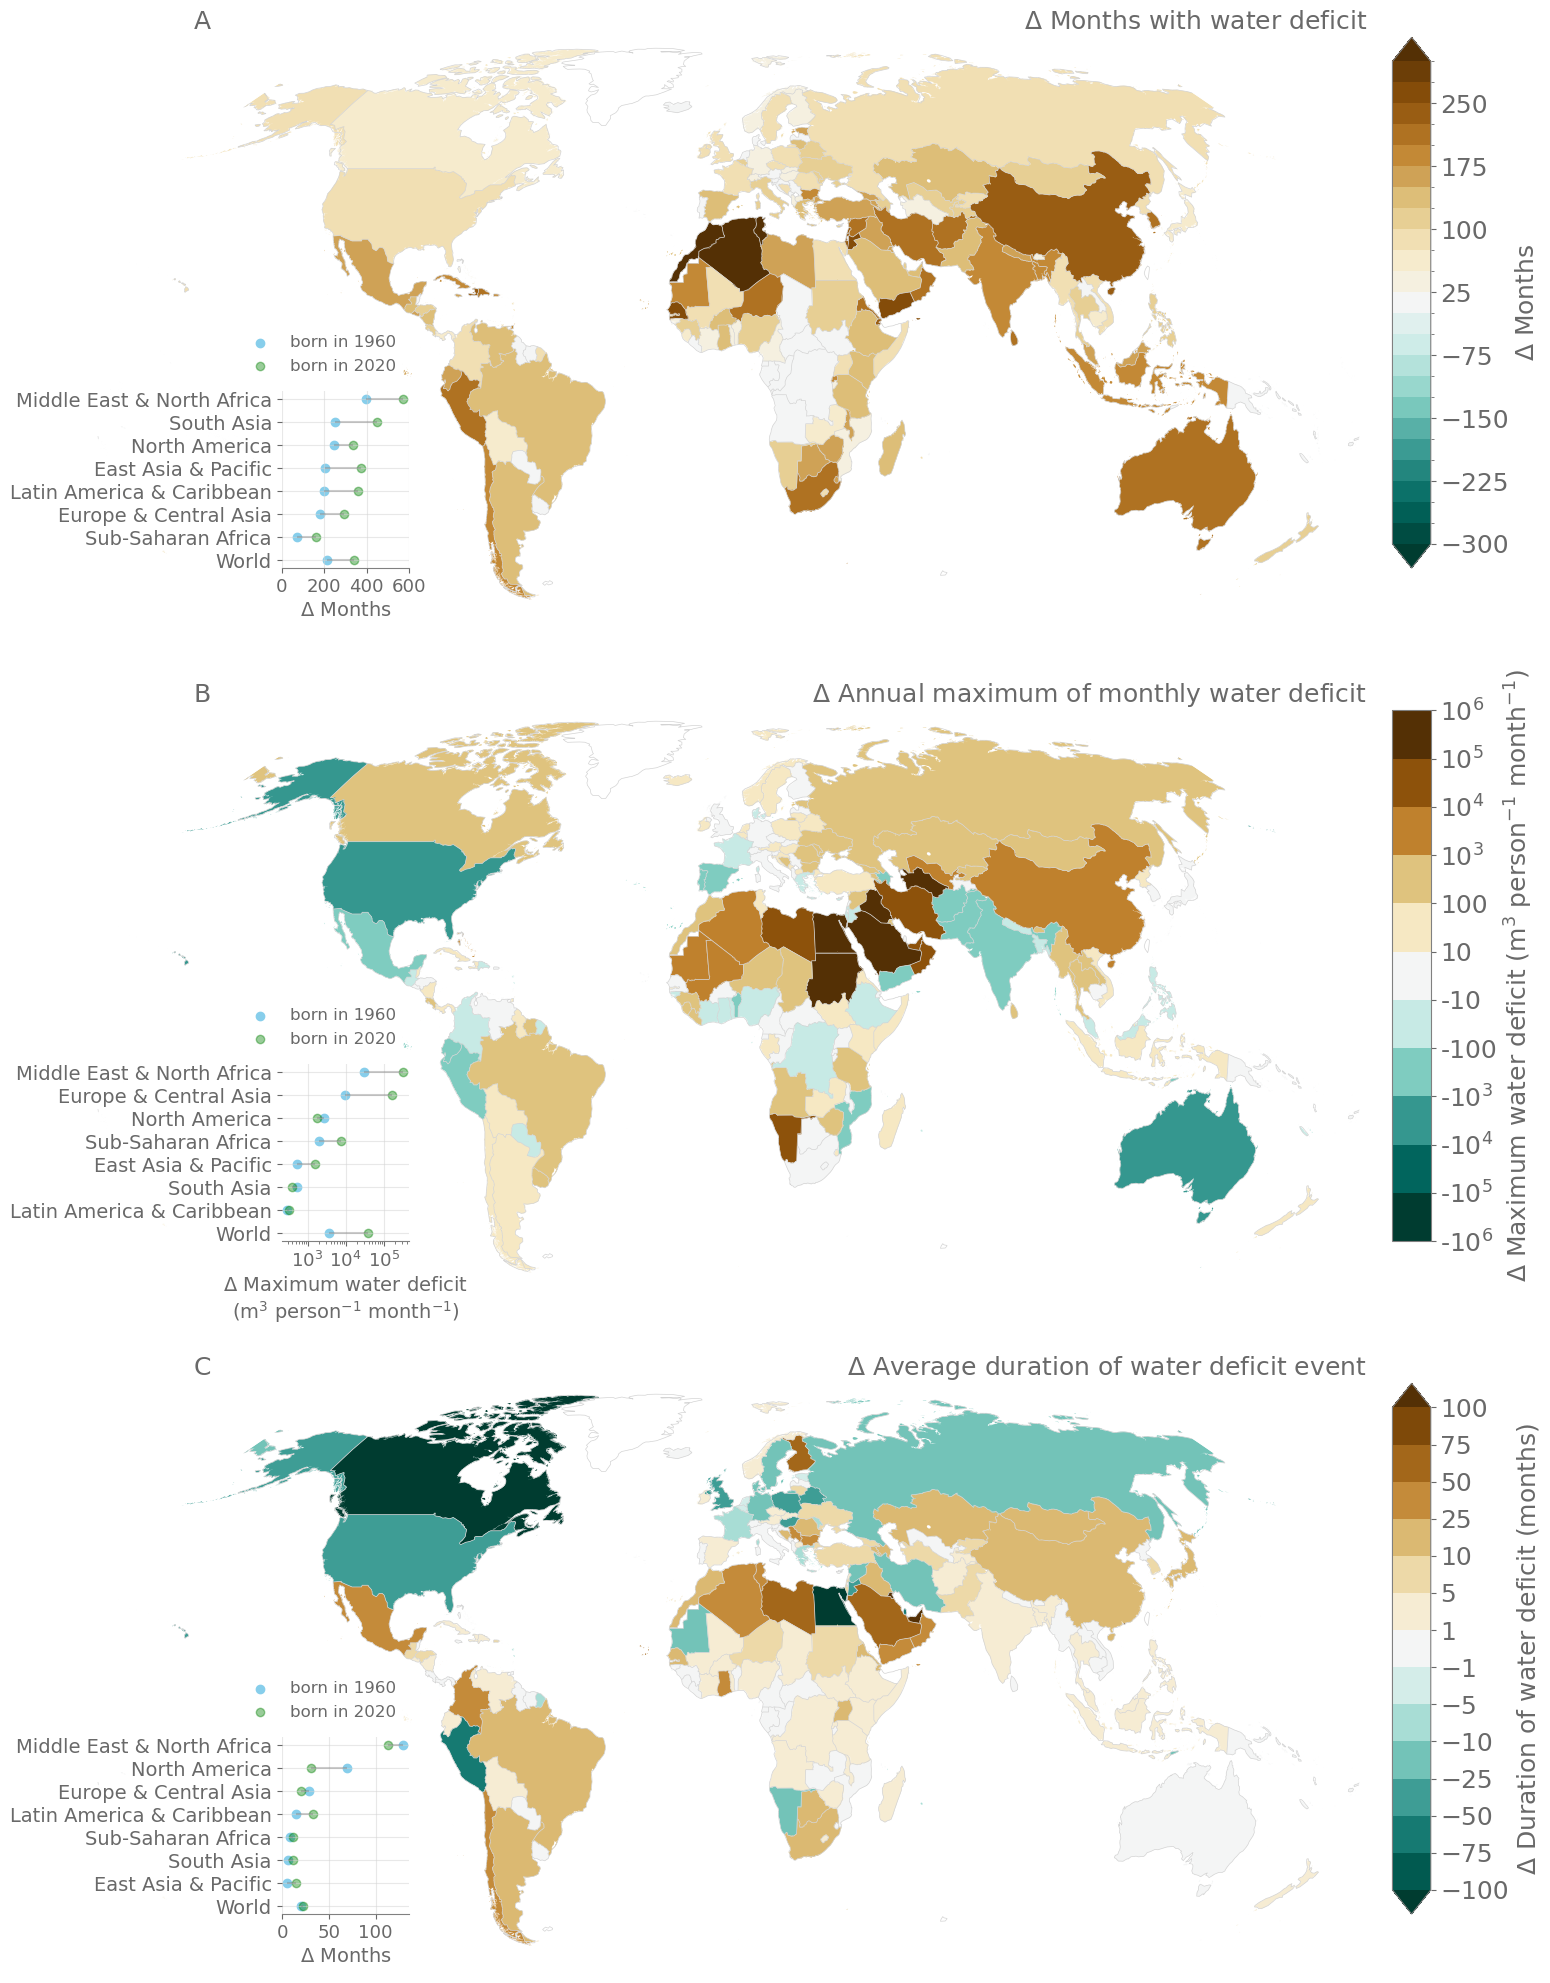

In [10]:
title_size = 18
inset_size = 14
labelsize= 18
labelsize_inset = 13

mpl.rc('ytick',labelsize=labelsize)
mpl.rc('axes',labelsize=labelsize)
mpl.rc('xtick',labelsize=labelsize)



rcp = rcps[0]
variable = 'mmm_'+rcp

fig, axes = plt.subplots(3,1,figsize=(40,20), subplot_kw={'projection':map_proj})
axes = axes.flatten()
offset = 10 # year (period to average isimip withdrawals on)


# -----------------------------------------------------------------------------------------
## Frequency

ax = axes[0]
da = ds_frequency[variable]

# select birth years and merge with gpd countries
birth_year = 1960
df = da.sel({'birth_year' : birth_year}).to_dataframe()
birth_year = 2020
df_2 = da.sel({'birth_year' : birth_year}).to_dataframe()


d_waterdeficit = (df_2-df)
legend_label = "$\Delta$ Months"
gdf_emf = gdf_country_borders.merge(d_waterdeficit, left_index=True, right_on='country')
bounds = np.arange(-300,350,50)
bounds = [-300,-275,-250,-225,-200,-175,-150,-125,-100,-75,-50,-25,25,50,75,100,125,150,175,200,225,250,275,300]
#bounds = np.arange(-250,300, 50)

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_emf.plot(ax=ax, column=variable, legend = True,  cmap='BrBG_r',  cax=cax, legend_kwds={'label': legend_label},  transform=ccrs.PlateCarree(),  norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'))
ax.set_title('$\Delta$ Months with water deficit', loc='right', size=title_size); 
ax.set_title('             A', loc='left', fontsize=title_size);

# ------------------------------------------------
# Panel d - inset lollipop plot
mpl.rc('axes',labelsize=labelsize_inset)
mpl.rc('xtick',labelsize=labelsize_inset)
ax_inset = ax.inset_axes([0.15, 0.1, 0.1, 0.3]) #[x0, y0, width, height]

# get values
df_temp = ds_frequency_perregion[variable].sel(birth_year=1960).to_dataframe().drop(['birth_year'],axis=1)
values_2020 = ds_frequency_perregion[variable].sel(birth_year=2020).values

values = np.stack((df_temp.index.values,np.squeeze(df_temp.values),values_2020))
df_1960 = pd.DataFrame(values.T, columns=['regions','1960','2020'])

regions_for_plot = regions['world'] + ["World"]
df = df_1960[df_1960["regions"].isin(regions_for_plot)].sort_values(by='1960',ascending=True) 
# Move "World" to the end
df = pd.concat([df[df['regions'] == 'World'], df[df['regions'] != 'World'] ], ignore_index=True)

my_range=range(1,len(df.index)+1)

# do plotting 
ax_inset.hlines(y=my_range, xmin=df['1960'], xmax=df['2020'], color='grey', alpha=0.4)
ax_inset.scatter(df['1960'], my_range, color='skyblue', alpha=1, label='born in 1960')
ax_inset.scatter(df['2020'], my_range, color='green', alpha=0.4 , label='born in 2020')

# plot settings
ax_inset.legend(bbox_to_anchor=(0.3,1.4), loc='upper center', frameon=False);
ax_inset.set_yticks(my_range)
ax_inset.set_yticklabels(df['regions'], fontsize=inset_size); 
ax_inset.spines[['right', 'left', 'top']].set_visible(False)    
ax_inset.set_xlabel('$\Delta$ Months', fontsize=inset_size)
ax_inset.set_xticks([0,200,400,600]);

ax_inset.grid(color='lightgray', alpha=0.5)
ax_inset.set_xlim((0,601));



# -----------------------------------------------------------------------------------------
## Intensity
mpl.rc('axes',labelsize=labelsize)
mpl.rc('xtick',labelsize=labelsize)

ax = axes[1]
da = ds_intensity[variable] 

# select birth years and merge with gpd countries
birth_year = 2020
df_2 = da.sel({'birth_year' : birth_year}).to_dataframe()

variable = 'mmm_'+rcp
da = ds_intensity[variable]

birth_year = 1960
df = da.sel({'birth_year' : birth_year}).to_dataframe()
birth_year = 2020
df_2 = da.sel({'birth_year' : birth_year}).to_dataframe()


d_waterdeficit = (df_2-df)
legend_label = "$\Delta$ Maximum water deficit (m$^3$ person$^{-1}$ month$^{-1}$)"
gdf_emf = gdf_country_borders.merge(d_waterdeficit * 1e-3, left_index=True, right_on='country')
bounds = np.array([-1000,-100,-10,-1,-0.1,-0.01,0.01,0.1,1,10,100,1e3])

tick_labels = ['-10$^6$','-10$^5$','-10$^4$','-10$^3$','-100','-10','10', '100','10$^3$','10$^4$','10$^5$','10$^6$'];
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_emf.plot(ax=ax, column=variable, legend = True,  cmap='BrBG_r',  cax=cax, legend_kwds={'label': legend_label },  transform=ccrs.PlateCarree(), norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256))
ax.set_title('$\Delta$ Annual maximum of monthly water deficit',  loc='right', size=title_size);
ax.set_title('             B', loc='left', fontsize=title_size);
cax.set_yticks(bounds);

cax.set_yticklabels(tick_labels);

# ------------------------------------------------
# Panel d - inset lollipop plot
mpl.rc('axes',labelsize=labelsize_inset)
mpl.rc('xtick',labelsize=labelsize_inset)
ax_inset = ax.inset_axes([0.15, 0.1, 0.1, 0.3]) #[x0, y0, width, height]

# get values
df_temp = ds_intensity_perregion[variable].sel(birth_year=1960).to_dataframe().drop(['birth_year'],axis=1)
values_2020 = ds_intensity_perregion[variable].sel(birth_year=2020).values

values = np.stack((df_temp.index.values,np.squeeze(df_temp.values),values_2020))
df_1960 = pd.DataFrame(values.T, columns=['regions','1960','2020'])

regions_for_plot = regions['world'] + ["World"]
df = df_1960[df_1960["regions"].isin(regions_for_plot)].sort_values(by='1960',ascending=True) 
# Move "World" to the end
df = pd.concat([df[df['regions'] == 'World'], df[df['regions'] != 'World'] ], ignore_index=True)

my_range=range(1,len(df.index)+1)

# do plotting 
ax_inset.hlines(y=my_range, xmin=df['1960'], xmax=df['2020'], color='grey', alpha=0.4)
ax_inset.scatter(df['1960'], my_range, color='skyblue', alpha=1, label='born in 1960')
ax_inset.scatter(df['2020'], my_range, color='green', alpha=0.4 , label='born in 2020')

# plot settings
ax_inset.legend(bbox_to_anchor=(0.3,1.4), loc='upper center', frameon=False);
ax_inset.set_yticks(my_range)

ax_inset.set_yticklabels(df['regions'], fontsize=inset_size); 
ax_inset.spines[['right', 'left', 'top']].set_visible(False)    
ax_inset.set_xlabel('$\Delta$ Maximum water deficit\n(m$^3$ person$^{-1}$ month$^{-1}$)', fontsize=inset_size)
ax_inset.grid(color='lightgray', alpha=0.5)
#ax_inset.set_xlim((0,500));
ax_inset.set_xscale('log')


# -----------------------------------------------------------------------------------------
## Duration
mpl.rc('axes',labelsize=labelsize)
mpl.rc('xtick',labelsize=labelsize)

ax = axes[2]

da = ds_duration[variable]

# select birth years and merge with gpd countries
birth_year = 2020
df_2 = da.sel({'birth_year' : birth_year}).to_dataframe()
birth_year = 1960
df = da.sel({'birth_year' : birth_year}).to_dataframe()


d_waterdeficit = (df_2-df)
legend_label = "$\Delta$ Duration of water deficit (months)"
gdf_emf = gdf_country_borders.merge(d_waterdeficit, left_index=True, right_on='country')
#bounds = np.array([-150,-100, -48, -24, -12, -10,-8,-6,-4 ,-2,0,2,4,6,8,10,12,24,48,100,150])
#bounds = np.array([-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,10,20,30,40,50,60,70,80,90,100])
#bounds = np.array([-120,-96,-72,-48,-24,-12,-6,-3,-1,1,3,6,12,24,48,72,96,120])
bounds = np.array([-100,-75,-50,-25,-10,-5,-1,1,5,10,25,50,75,100])
bounds = np.array([-100,-75,-50,-25,-10,-5,-1,1,5,10,25,50,75,100])
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_emf.plot(ax=ax, column=variable, legend = True,  cmap='BrBG_r',  cax=cax, legend_kwds={'label': legend_label},  transform=ccrs.PlateCarree(), norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'))
ax.set_title('$\Delta$ Average duration of water deficit event',  loc='right', size=title_size);
ax.set_title('             C', loc='left', fontsize=title_size);

cax.set_yticks(bounds)
#cax.set_yticklabels(ticklabels)


# ------------------------------------------------
# Panel d - inset lollipop plot
mpl.rc('axes',labelsize=labelsize_inset)
mpl.rc('xtick',labelsize=labelsize_inset)

ax_inset = ax.inset_axes([0.15, 0.1, 0.1, 0.3]) #[x0, y0, width, height]

# get values
df_temp = ds_duration_perregion[variable].sel(birth_year=1960).to_dataframe().drop(['birth_year'],axis=1)
values_2020 = ds_duration_perregion[variable].sel(birth_year=2020).values

values = np.stack((df_temp.index.values,np.squeeze(df_temp.values),values_2020))
df_1960 = pd.DataFrame(values.T, columns=['regions','1960','2020'])

regions_for_plot = regions['world'] + ["World"]
df = df_1960[df_1960["regions"].isin(regions_for_plot)].sort_values(by='1960',ascending=True) 
# Move "World" to the end
df = pd.concat([df[df['regions'] == 'World'], df[df['regions'] != 'World'] ], ignore_index=True)

my_range=range(1,len(df.index)+1)


# do plotting 
ax_inset.hlines(y=my_range, xmin=df['1960'], xmax=df['2020'], color='grey', alpha=0.4)
ax_inset.scatter(df['1960'], my_range, color='skyblue', alpha=1, label='born in 1960')
ax_inset.scatter(df['2020'], my_range, color='green', alpha=0.4 , label='born in 2020')

# plot settings
ax_inset.legend(bbox_to_anchor=(0.3,1.4), loc='upper center', frameon=False);
ax_inset.set_yticks(my_range)
ax_inset.set_yticklabels(df['regions'], fontsize=inset_size); 
ax_inset.spines[['right', 'left', 'top']].set_visible(False)    
ax_inset.set_xticks([0,50,100]);
ax_inset.set_xlabel('$\Delta$ Months', fontsize=inset_size)
ax_inset.grid(color='lightgray', alpha=0.5)

fig.tight_layout()
plt.savefig('/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/lifetime_exposure_isimip/figures/IDF.png', bbox_inches='tight',dpi=600)




### Values

In [7]:
# Generational difference in frequency (nmonths)
print(f"Generational difference in frequency (nmonths)")
print(" ")

da = ds_frequency_perregion['mmm_RCP60']
df_1960 = da.sel({'birth_year' : 1960}).to_dataframe()
df_2020 = da.sel({'birth_year' : 2020}).to_dataframe()

selected_regions = ['Middle East & North Africa', 'South Asia']
for region in selected_regions: 
    print(f"{region} 1960 birth cohort: {int(df_1960.loc[region].values[1])} months")
    print(f"{region} 2020 birth cohort: {int(df_2020.loc[region].values[1])} months")
    print(f"Difference in years: {(df_2020.loc[region].values[1]-df_1960.loc[region].values[1])/12:0.1f}")
    print(" ")

    
# Generational difference in intensity (m3/month)
print(f"Generational difference in intensity (m3/personyear)")
print(" ")

da = ds_intensity_perregion['mmm_RCP60']
df_1960 = da.sel({'birth_year' : 1960}).to_dataframe()
df_2020 = da.sel({'birth_year' : 2020}).to_dataframe()

selected_regions = ['Middle East & North Africa', 'Europe & Central Asia',  'North America']
for region in selected_regions: 
    print(f"{region} 1960 birth cohort: {df_1960.loc[region].values[1]*10**(-3):0.2f} m3/personyear")
    print(f"{region} 2020 birth cohort: {df_2020.loc[region].values[1]*10**(-3):0.2f} m3/personyear")
    print(f"Difference: {(df_2020.loc[region].values[1]-df_1960.loc[region].values[1])*10**(-3):0.2f}")
    print(" ")


Generational difference in frequency (nmonths)
 
Middle East & North Africa 1960 birth cohort: 398 months
Middle East & North Africa 2020 birth cohort: 571 months
Difference in years: 14.5
 
South Asia 1960 birth cohort: 252 months
South Asia 2020 birth cohort: 447 months
Difference in years: 16.3
 
Generational difference in intensity (m3/personyear)
 
Middle East & North Africa 1960 birth cohort: 29.71 m3/personyear
Middle East & North Africa 2020 birth cohort: 326.76 m3/personyear
Difference: 297.05
 
Europe & Central Asia 1960 birth cohort: 9.86 m3/personyear
Europe & Central Asia 2020 birth cohort: 161.05 m3/personyear
Difference: 151.19
 
North America 1960 birth cohort: 2.78 m3/personyear
North America 2020 birth cohort: 1.75 m3/personyear
Difference: -1.04
 


#### RCP 2.6

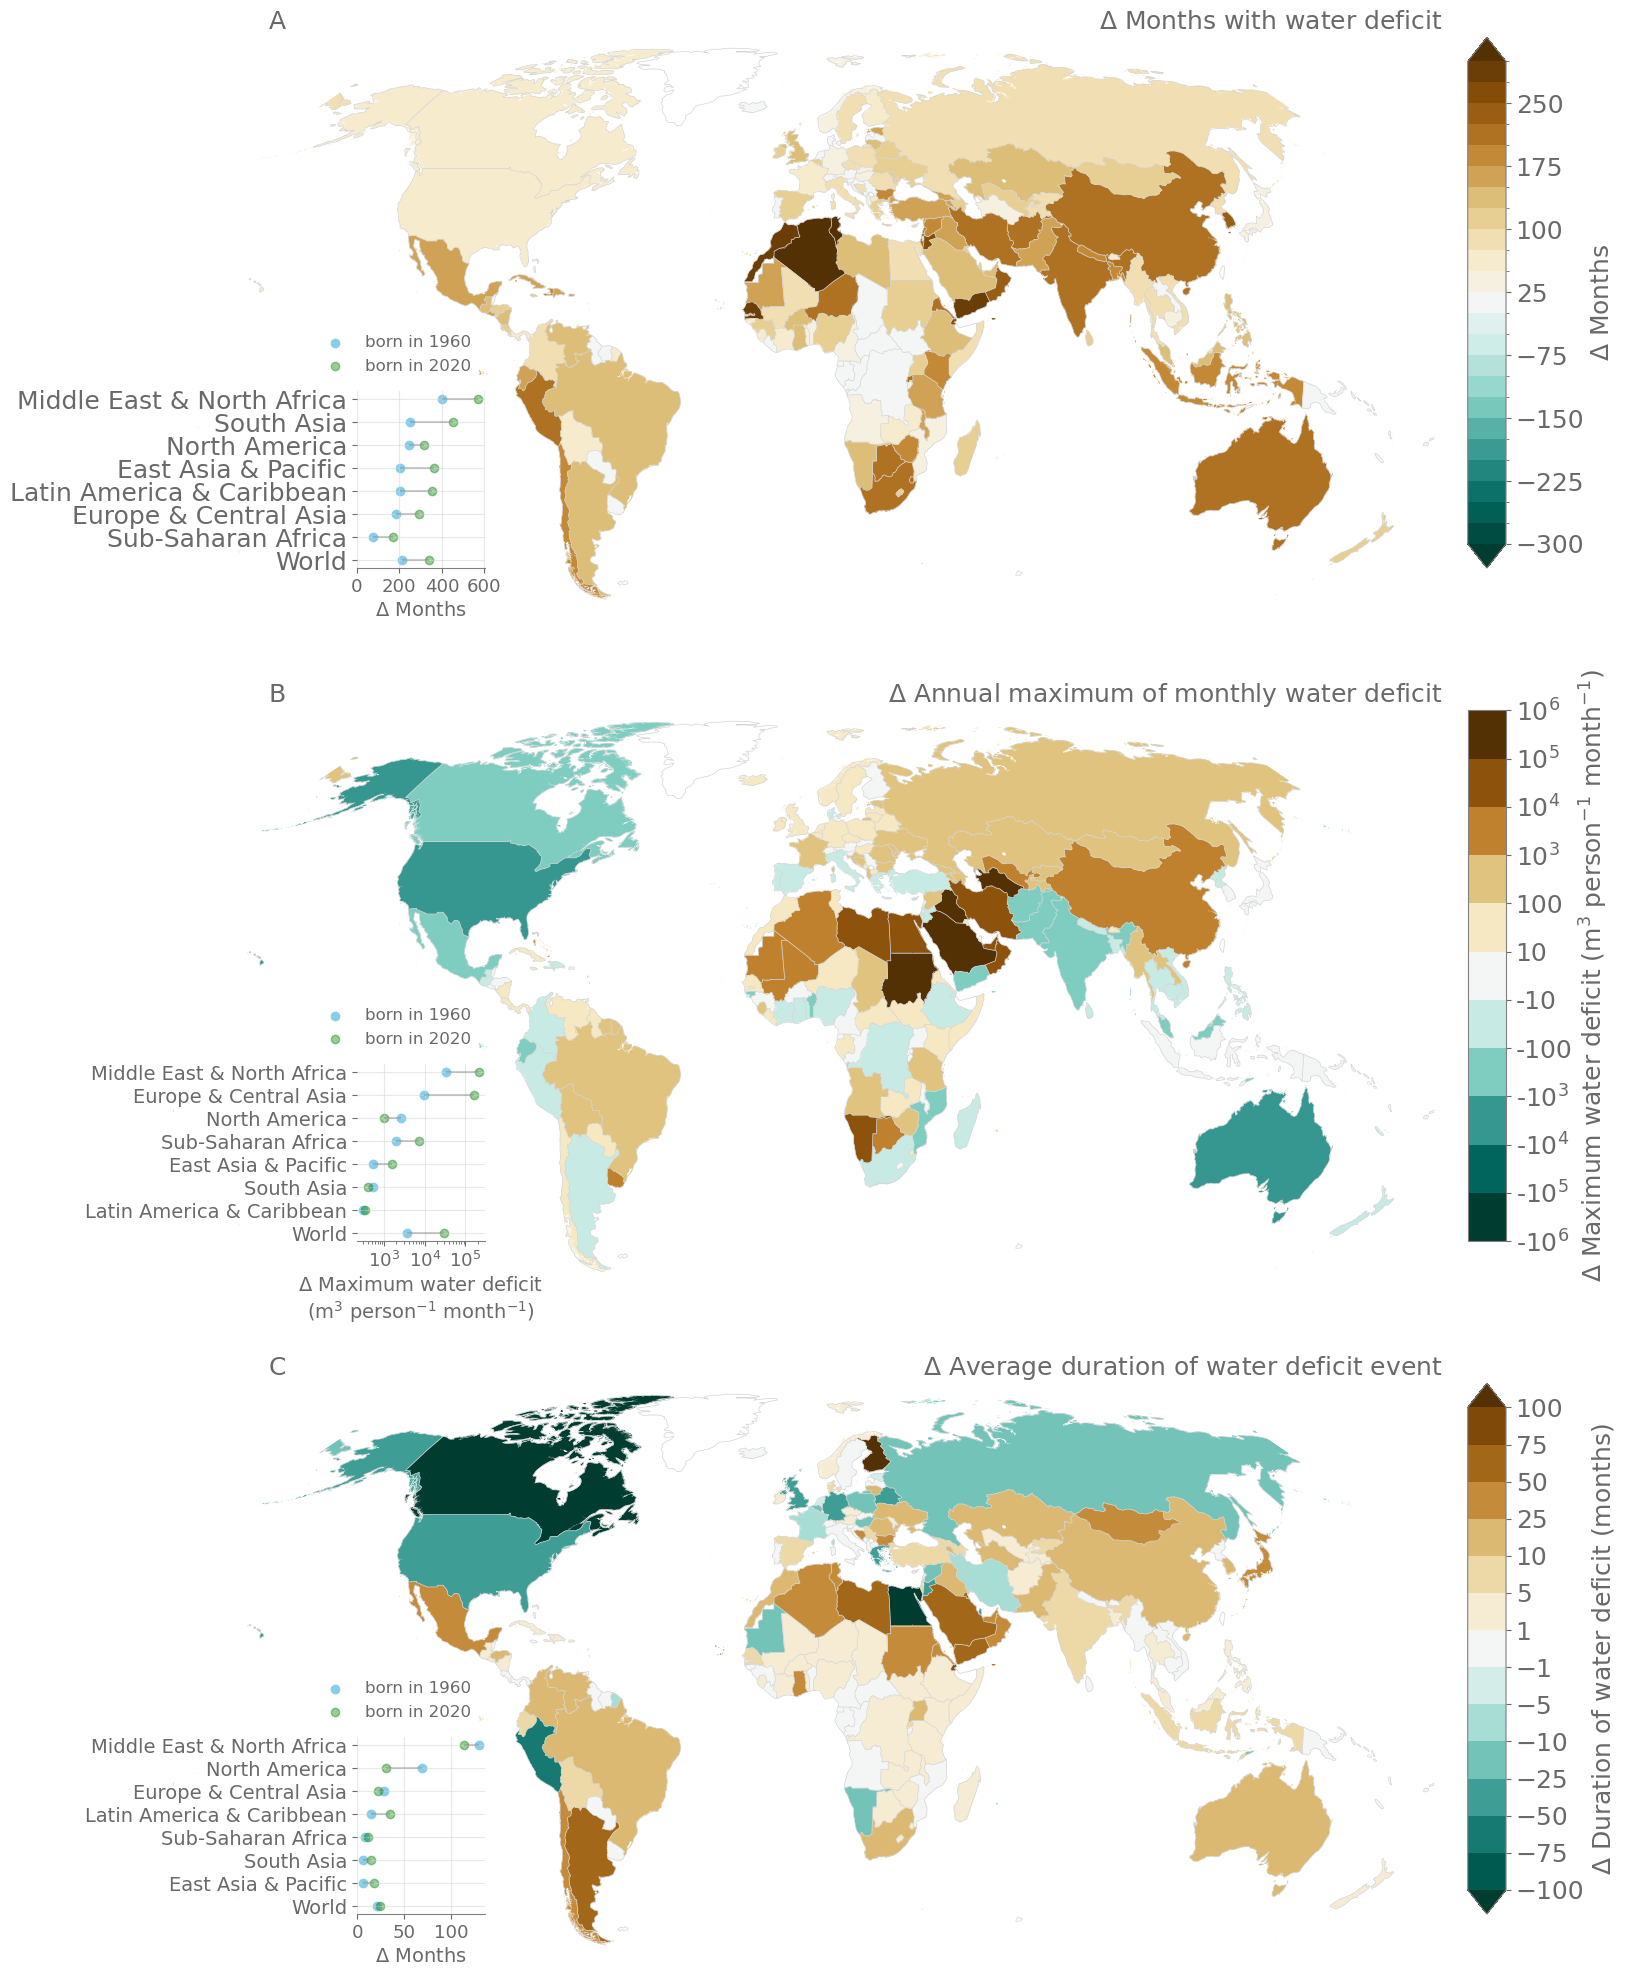

In [12]:
title_size = 18
inset_size = 14
labelsize= 18
labelsize_inset = 13

mpl.rc('ytick',labelsize=labelsize)
mpl.rc('axes',labelsize=labelsize)
mpl.rc('xtick',labelsize=labelsize)



rcp = rcps[1]
variable = 'mmm_'+rcp

fig, axes = plt.subplots(3,1,figsize=(40,20), subplot_kw={'projection':map_proj})
axes = axes.flatten()
offset = 10 # year (period to average isimip withdrawals on)


# -----------------------------------------------------------------------------------------
## Frequency

ax = axes[0]
da = ds_frequency[variable]

# select birth years and merge with gpd countries
birth_year = 1960
df = da.sel({'birth_year' : birth_year}).to_dataframe()
birth_year = 2020
df_2 = da.sel({'birth_year' : birth_year}).to_dataframe()


d_waterdeficit = (df_2-df)
legend_label = "$\Delta$ Months"
gdf_emf = gdf_country_borders.merge(d_waterdeficit, left_index=True, right_on='country')
bounds = np.arange(-300,350,50)
bounds = [-300,-275,-250,-225,-200,-175,-150,-125,-100,-75,-50,-25,25,50,75,100,125,150,175,200,225,250,275,300]
#bounds = np.arange(-250,300, 50)

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_emf.plot(ax=ax, column=variable, legend = True,  cmap='BrBG_r',  cax=cax, legend_kwds={'label': legend_label},  transform=ccrs.PlateCarree(),  norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'))
ax.set_title('$\Delta$ Months with water deficit', loc='right', size=title_size); 
ax.set_title('             A', loc='left', fontsize=title_size);

# ------------------------------------------------
# Panel d - inset lollipop plot
mpl.rc('axes',labelsize=labelsize_inset)
mpl.rc('xtick',labelsize=labelsize_inset)
ax_inset = ax.inset_axes([0.15, 0.1, 0.1, 0.3]) #[x0, y0, width, height]

# get values
df_temp = ds_frequency_perregion[variable].sel(birth_year=1960).to_dataframe().drop(['birth_year'],axis=1)
values_2020 = ds_frequency_perregion[variable].sel(birth_year=2020).values

values = np.stack((df_temp.index.values,np.squeeze(df_temp.values),values_2020))
df_1960 = pd.DataFrame(values.T, columns=['regions','1960','2020'])

regions_for_plot = regions['world'] + ["World"]
df = df_1960[df_1960["regions"].isin(regions_for_plot)].sort_values(by='1960',ascending=True) 
# Move "World" to the end
df = pd.concat([df[df['regions'] == 'World'], df[df['regions'] != 'World'] ], ignore_index=True)

my_range=range(1,len(df.index)+1)

# do plotting 
ax_inset.hlines(y=my_range, xmin=df['1960'], xmax=df['2020'], color='grey', alpha=0.4)
ax_inset.scatter(df['1960'], my_range, color='skyblue', alpha=1, label='born in 1960')
ax_inset.scatter(df['2020'], my_range, color='green', alpha=0.4 , label='born in 2020')

# plot settings
ax_inset.legend(bbox_to_anchor=(0.3,1.4), loc='upper center', frameon=False);
ax_inset.set_yticks(my_range)
ax_inset.set_yticklabels(df['regions']); 
ax_inset.spines[['right', 'left', 'top']].set_visible(False)    
ax_inset.set_xlabel('$\Delta$ Months', fontsize=inset_size)
ax_inset.set_xticks([0,200,400,600]);

ax_inset.grid(color='lightgray', alpha=0.5)
ax_inset.set_xlim((0,601));



# -----------------------------------------------------------------------------------------
## Intensity
mpl.rc('axes',labelsize=labelsize)
mpl.rc('xtick',labelsize=labelsize)

ax = axes[1]
da = ds_intensity[variable] 

# select birth years and merge with gpd countries
birth_year = 2020
df_2 = da.sel({'birth_year' : birth_year}).to_dataframe()

variable = 'mmm_'+rcp
da = ds_intensity[variable]

birth_year = 1960
df = da.sel({'birth_year' : birth_year}).to_dataframe()
birth_year = 2020
df_2 = da.sel({'birth_year' : birth_year}).to_dataframe()


d_waterdeficit = (df_2-df)
legend_label = "$\Delta$ Maximum water deficit (m$^3$ person$^{-1}$ month$^{-1}$)"
gdf_emf = gdf_country_borders.merge(d_waterdeficit * 1e-3, left_index=True, right_on='country')
bounds = np.array([-1000,-100,-10,-1,-0.1,-0.01,0.01,0.1,1,10,100,1e3])

tick_labels = ['-10$^6$','-10$^5$','-10$^4$','-10$^3$','-100','-10','10', '100','10$^3$','10$^4$','10$^5$','10$^6$'];
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_emf.plot(ax=ax, column=variable, legend = True,  cmap='BrBG_r',  cax=cax, legend_kwds={'label': legend_label },  transform=ccrs.PlateCarree(), norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256))
ax.set_title('$\Delta$ Annual maximum of monthly water deficit',  loc='right', size=title_size);
ax.set_title('             B', loc='left', fontsize=title_size);
cax.set_yticks(bounds);

cax.set_yticklabels(tick_labels);

# ------------------------------------------------
# Panel d - inset lollipop plot
mpl.rc('axes',labelsize=labelsize_inset)
mpl.rc('xtick',labelsize=labelsize_inset)
ax_inset = ax.inset_axes([0.15, 0.1, 0.1, 0.3]) #[x0, y0, width, height]

# get values
df_temp = ds_intensity_perregion[variable].sel(birth_year=1960).to_dataframe().drop(['birth_year'],axis=1)
values_2020 = ds_intensity_perregion[variable].sel(birth_year=2020).values

values = np.stack((df_temp.index.values,np.squeeze(df_temp.values),values_2020))
df_1960 = pd.DataFrame(values.T, columns=['regions','1960','2020'])

regions_for_plot = regions['world'] + ["World"]
df = df_1960[df_1960["regions"].isin(regions_for_plot)].sort_values(by='1960',ascending=True) 
# Move "World" to the end
df = pd.concat([df[df['regions'] == 'World'], df[df['regions'] != 'World'] ], ignore_index=True)

my_range=range(1,len(df.index)+1)

# do plotting 
ax_inset.hlines(y=my_range, xmin=df['1960'], xmax=df['2020'], color='grey', alpha=0.4)
ax_inset.scatter(df['1960'], my_range, color='skyblue', alpha=1, label='born in 1960')
ax_inset.scatter(df['2020'], my_range, color='green', alpha=0.4 , label='born in 2020')

# plot settings
ax_inset.legend(bbox_to_anchor=(0.3,1.4), loc='upper center', frameon=False);
ax_inset.set_yticks(my_range)
ax_inset.set_yticklabels(df['regions'], fontsize=inset_size); 
ax_inset.spines[['right', 'left', 'top']].set_visible(False)    
ax_inset.set_xlabel('$\Delta$ Maximum water deficit\n(m$^3$ person$^{-1}$ month$^{-1}$)', fontsize=inset_size)
ax_inset.grid(color='lightgray', alpha=0.5)
#ax_inset.set_xlim((0,500));
ax_inset.set_xscale('log')



# -----------------------------------------------------------------------------------------
## Duration
mpl.rc('axes',labelsize=labelsize)
mpl.rc('xtick',labelsize=labelsize)

ax = axes[2]

da = ds_duration[variable]

# select birth years and merge with gpd countries
birth_year = 2020
df_2 = da.sel({'birth_year' : birth_year}).to_dataframe()
birth_year = 1960
df = da.sel({'birth_year' : birth_year}).to_dataframe()


d_waterdeficit = (df_2-df)
legend_label = "$\Delta$ Duration of water deficit (months)"
gdf_emf = gdf_country_borders.merge(d_waterdeficit, left_index=True, right_on='country')
#bounds = np.array([-150,-100, -48, -24, -12, -10,-8,-6,-4 ,-2,0,2,4,6,8,10,12,24,48,100,150])
#bounds = np.array([-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,10,20,30,40,50,60,70,80,90,100])
#bounds = np.array([-120,-96,-72,-48,-24,-12,-6,-3,-1,1,3,6,12,24,48,72,96,120])
bounds = np.array([-100,-75,-50,-25,-10,-5,-1,1,5,10,25,50,75,100])
bounds = np.array([-100,-75,-50,-25,-10,-5,-1,1,5,10,25,50,75,100])
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_emf.plot(ax=ax, column=variable, legend = True,  cmap='BrBG_r',  cax=cax, legend_kwds={'label': legend_label},  transform=ccrs.PlateCarree(), norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'))
ax.set_title('$\Delta$ Average duration of water deficit event',  loc='right', size=title_size);
ax.set_title('             C', loc='left', fontsize=title_size);

cax.set_yticks(bounds)
#cax.set_yticklabels(ticklabels)


# ------------------------------------------------
# Panel d - inset lollipop plot
mpl.rc('axes',labelsize=labelsize_inset)
mpl.rc('xtick',labelsize=labelsize_inset)

ax_inset = ax.inset_axes([0.15, 0.1, 0.1, 0.3]) #[x0, y0, width, height]

# get values
df_temp = ds_duration_perregion[variable].sel(birth_year=1960).to_dataframe().drop(['birth_year'],axis=1)
values_2020 = ds_duration_perregion[variable].sel(birth_year=2020).values

values = np.stack((df_temp.index.values,np.squeeze(df_temp.values),values_2020))
df_1960 = pd.DataFrame(values.T, columns=['regions','1960','2020'])

regions_for_plot = regions['world'] + ["World"]
df = df_1960[df_1960["regions"].isin(regions_for_plot)].sort_values(by='1960',ascending=True) 
# Move "World" to the end
df = pd.concat([df[df['regions'] == 'World'], df[df['regions'] != 'World'] ], ignore_index=True)

my_range=range(1,len(df.index)+1)

# do plotting 
ax_inset.hlines(y=my_range, xmin=df['1960'], xmax=df['2020'], color='grey', alpha=0.4)
ax_inset.scatter(df['1960'], my_range, color='skyblue', alpha=1, label='born in 1960')
ax_inset.scatter(df['2020'], my_range, color='green', alpha=0.4 , label='born in 2020')

# plot settings
ax_inset.legend(bbox_to_anchor=(0.3,1.4), loc='upper center', frameon=False);
ax_inset.set_yticks(my_range)
ax_inset.set_yticklabels(df['regions'], fontsize=inset_size); 
ax_inset.spines[['right', 'left', 'top']].set_visible(False)    
ax_inset.set_xticks([0,50,100]);
ax_inset.set_xlabel('$\Delta$ Months', fontsize=inset_size)
ax_inset.grid(color='lightgray', alpha=0.5)

fig.tight_layout()
plt.savefig('/scratch/brussel/vo/000/bvo00012/vsc10055/waterscarcity/lifetime_exposure_isimip/figures/IDF_rcp26.png', bbox_inches='tight',dpi=600)




## Frequency

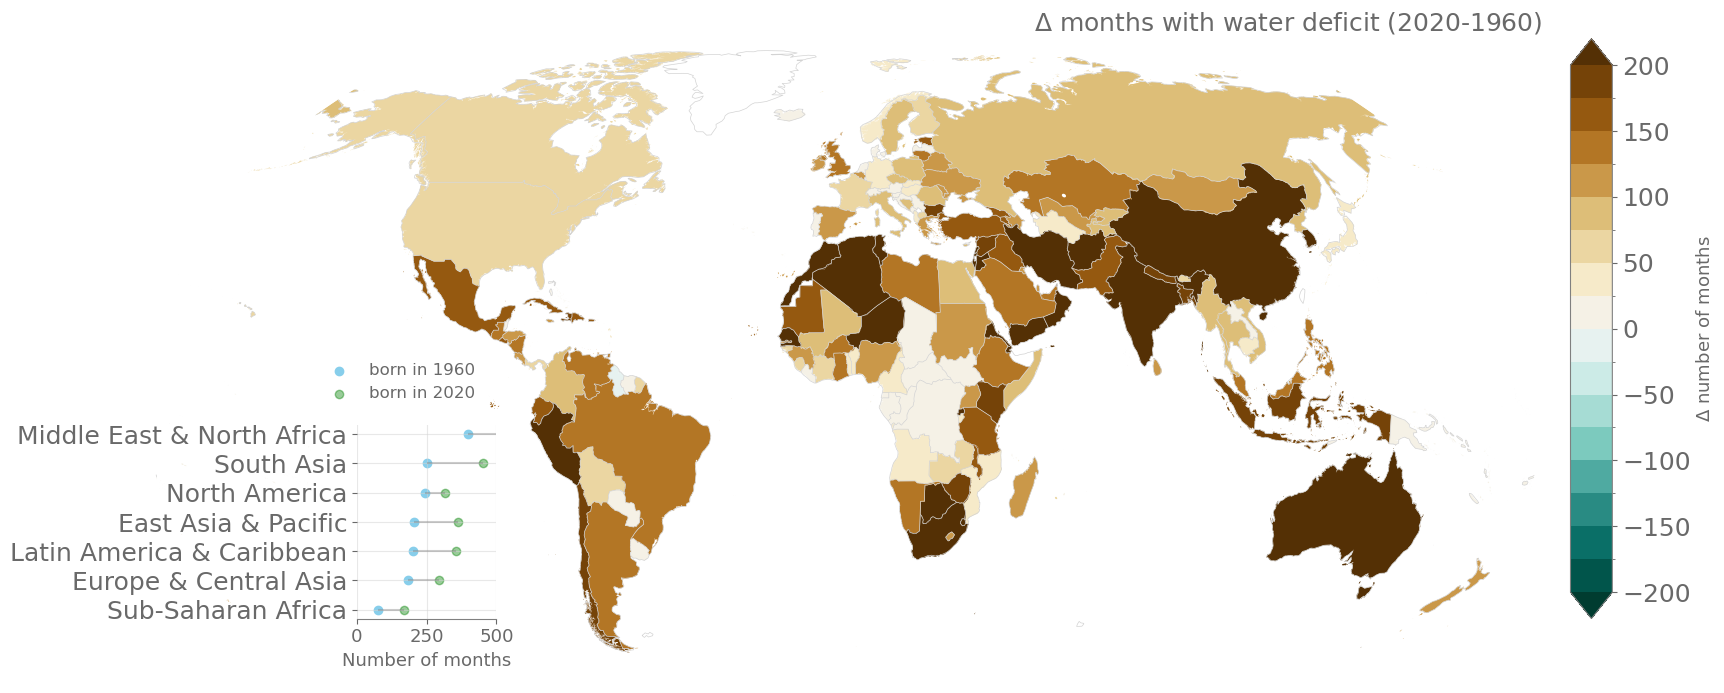

In [9]:
da = ds_frequency[variable]

# select birth years and merge with gpd countries
birth_year = 1960
df = da.sel({'birth_year' : birth_year}).to_dataframe()
birth_year = 2020
df_2 = da.sel({'birth_year' : birth_year}).to_dataframe()



d_waterdeficit = (df_2-df)
legend_label = "$\Delta$ number of months"
gdf_emf = gdf_country_borders.merge(d_waterdeficit, left_index=True, right_on='country')
bounds = np.arange(-300,350,50)
bounds = [-350,-300,-250,-200,-150,-100,-50,50,100,150,200,250,300,350]
bounds = np.arange(-200,225, 25)

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_emf.plot(ax=ax, column=variable, legend = True,  cmap='BrBG_r',  cax=cax, legend_kwds={'label': legend_label},  transform=ccrs.PlateCarree(),  norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'))
ax.set_title('$\Delta$ Average duration of water deficit event (2020-1960) '+rcp_text[rcp],  loc='right');
ax.set_title('$\Delta$ months with water deficit (2020-1960)', loc='right', size=18); 


# ------------------------------------------------
# Panel d - inset lollipop plot

ax_inset = ax.inset_axes([0.15, 0.1, 0.1, 0.3]) #[x0, y0, width, height]

# get values
df_temp = ds_frequency_perregion[variable].sel(birth_year=1960).to_dataframe().drop(['birth_year'],axis=1)
values_2020 = ds_frequency_perregion[variable].sel(birth_year=2020).values

values = np.stack((df_temp.index.values,np.squeeze(df_temp.values),values_2020))
df_1960 = pd.DataFrame(values.T, columns=['regions','1960','2020'])

df = df_1960[df_1960["regions"].isin(regions['world'])].sort_values(by='1960',ascending=True) 

my_range=range(1,len(df.index)+1)

# do plotting 
ax_inset.hlines(y=my_range, xmin=df['1960'], xmax=df['2020'], color='grey', alpha=0.4)
ax_inset.scatter(df['1960'], my_range, color='skyblue', alpha=1, label='born in 1960')
ax_inset.scatter(df['2020'], my_range, color='green', alpha=0.4 , label='born in 2020')

# plot settings
ax_inset.legend(bbox_to_anchor=(0.3,1.4), loc='upper center', frameon=False);
ax_inset.set_yticks(my_range)
ax_inset.set_yticklabels(df['regions']); 
ax_inset.spines[['right', 'left', 'top']].set_visible(False)    
ax_inset.set_xlabel('Number of months')
ax_inset.grid(color='lightgray', alpha=0.5)
ax_inset.set_xlim((0,500));


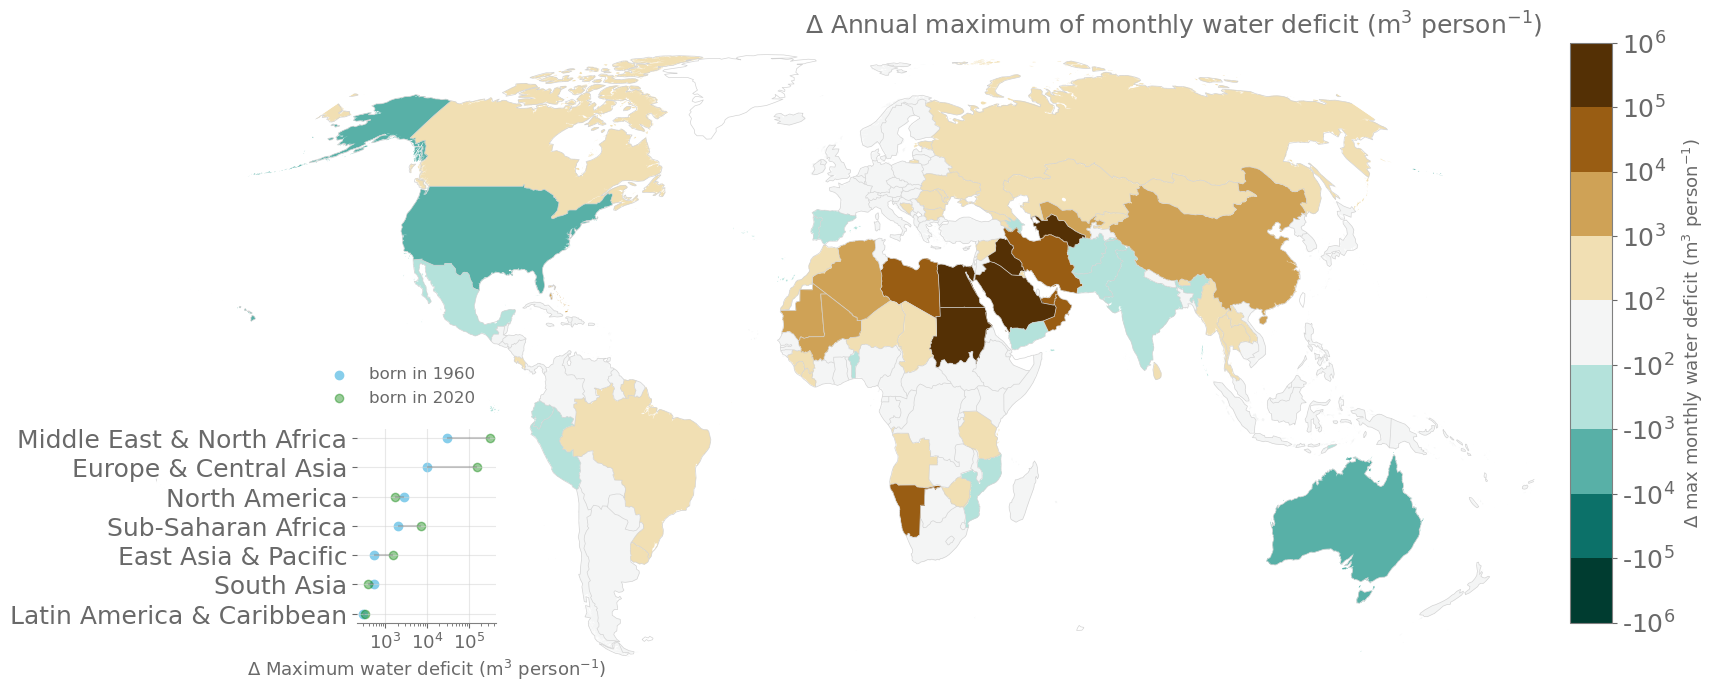

In [10]:
rcp = rcps[0]
variable = 'mmm_'+rcp
da = ds_intensity[variable] 

# select birth years and merge with gpd countries
birth_year = 2020
df_2 = da.sel({'birth_year' : birth_year}).to_dataframe()

variable = 'mmm_'+rcp
da = ds_intensity[variable]

birth_year = 1960
df = da.sel({'birth_year' : birth_year}).to_dataframe()
birth_year = 2020
df_2 = da.sel({'birth_year' : birth_year}).to_dataframe()



d_waterdeficit = (df_2-df)
legend_label = "$\Delta$ max monthly water deficit (m$^3$ person$^{-1}$)"
gdf_emf = gdf_country_borders.merge(d_waterdeficit, left_index=True, right_on='country')
bounds = np.array([-1e6,-1e5,-1e4,-1000,-100,100,1000,1e4,1e5,1e6])

tick_labels = ['-10$^6$','-10$^5$','-10$^4$','-10$^3$','-10$^2$', '10$^2$','10$^3$','10$^4$','10$^5$','10$^6$'];


fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_emf.plot(ax=ax, column=variable, legend = True,  cmap='BrBG_r',  cax=cax, legend_kwds={'label': legend_label },  transform=ccrs.PlateCarree(), norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256))
ax.set_title('$\Delta$ Annual maximum of monthly water deficit (m$^3$ person$^{-1}$)',  loc='right', size=18);

cax.set_yticklabels(tick_labels);


# ------------------------------------------------
# Panel d - inset lollipop plot

ax_inset = ax.inset_axes([0.15, 0.1, 0.1, 0.3]) #[x0, y0, width, height]

# get values
df_temp = ds_intensity_perregion[variable].sel(birth_year=1960).to_dataframe().drop(['birth_year'],axis=1)
values_2020 = ds_intensity_perregion[variable].sel(birth_year=2020).values

values = np.stack((df_temp.index.values,np.squeeze(df_temp.values),values_2020))
df_1960 = pd.DataFrame(values.T, columns=['regions','1960','2020'])

df = df_1960[df_1960["regions"].isin(regions['world'])].sort_values(by='1960',ascending=True) 

my_range=range(1,len(df.index)+1)

# do plotting 
ax_inset.hlines(y=my_range, xmin=df['1960'], xmax=df['2020'], color='grey', alpha=0.4)
ax_inset.scatter(df['1960'], my_range, color='skyblue', alpha=1, label='born in 1960')
ax_inset.scatter(df['2020'], my_range, color='green', alpha=0.4 , label='born in 2020')

# plot settings
ax_inset.legend(bbox_to_anchor=(0.3,1.4), loc='upper center', frameon=False);
ax_inset.set_yticks(my_range)
ax_inset.set_yticklabels(df['regions']); 
ax_inset.spines[['right', 'left', 'top']].set_visible(False)    
ax_inset.set_xlabel('$\Delta$ Maximum water deficit (m$^3$ person$^{-1}$)')
ax_inset.grid(color='lightgray', alpha=0.5)
#ax_inset.set_xlim((0,500));
ax_inset.set_xscale('log')

## Duration

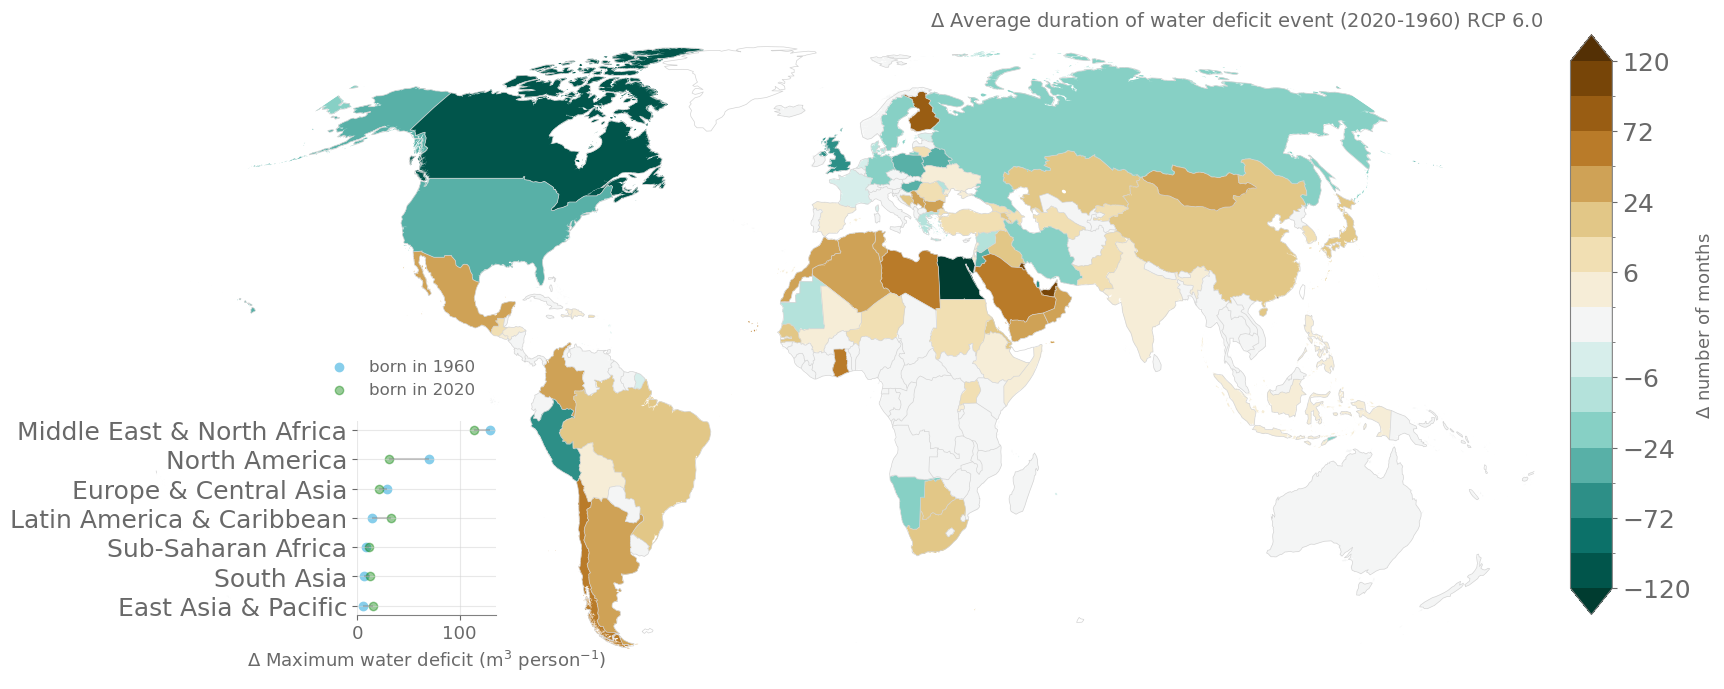

In [16]:
rcp = rcps[0]

variable = 'mmm_'+rcp
da = ds_duration[variable]

# select birth years and merge with gpd countries
birth_year = 2020
df_2 = da.sel({'birth_year' : birth_year}).to_dataframe()
birth_year = 1960
df = da.sel({'birth_year' : birth_year}).to_dataframe()



d_waterdeficit = (df_2-df)
legend_label = "$\Delta$ number of months"
gdf_emf = gdf_country_borders.merge(d_waterdeficit, left_index=True, right_on='country')
#bounds = np.array([-150,-100, -48, -24, -12, -10,-8,-6,-4 ,-2,0,2,4,6,8,10,12,24,48,100,150])
bounds = np.array([-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,10,20,30,40,50,60,70,80,90,100])
bounds = np.array([-120,-96,-72,-48,-24,-12,-6,-3,3,6,12,24,48,72,96,120])
ticks = np.array ([-120,    -72,    -24,    -6,     6,   24,   72,   120])
ticklabels = ['-10 years', '-6 years','-2 years','-0.5 years', '0.5 years', '2 years','6 years','10 years']
fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_emf.plot(ax=ax, column=variable, legend = True,  cmap='BrBG_r',  cax=cax, legend_kwds={'label': legend_label},  transform=ccrs.PlateCarree(), norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'))
ax.set_title('$\Delta$ Average duration of water deficit event (2020-1960) '+rcp_text[rcp],  loc='right');
cax.set_yticks(ticks)

#cax.set_yticklabels(ticklabels)


# ------------------------------------------------
# Panel d - inset lollipop plot

ax_inset = ax.inset_axes([0.15, 0.1, 0.1, 0.3]) #[x0, y0, width, height]

# get values
df_temp = ds_duration_perregion[variable].sel(birth_year=1960).to_dataframe().drop(['birth_year'],axis=1)
values_2020 = ds_duration_perregion[variable].sel(birth_year=2020).values

values = np.stack((df_temp.index.values,np.squeeze(df_temp.values),values_2020))
df_1960 = pd.DataFrame(values.T, columns=['regions','1960','2020'])

df = df_1960[df_1960["regions"].isin(regions['world'])].sort_values(by='1960',ascending=True) 

my_range=range(1,len(df.index)+1)

# do plotting 
ax_inset.hlines(y=my_range, xmin=df['1960'], xmax=df['2020'], color='grey', alpha=0.4)
ax_inset.scatter(df['1960'], my_range, color='skyblue', alpha=1, label='born in 1960')
ax_inset.scatter(df['2020'], my_range, color='green', alpha=0.4 , label='born in 2020')

# plot settings
ax_inset.legend(bbox_to_anchor=(0.3,1.4), loc='upper center', frameon=False);
ax_inset.set_yticks(my_range)
ax_inset.set_yticklabels(df['regions']); 
ax_inset.spines[['right', 'left', 'top']].set_visible(False)    
ax_inset.set_xlabel('$\Delta$ Maximum water deficit (m$^3$ person$^{-1}$)')
ax_inset.grid(color='lightgray', alpha=0.5)
